# **Other Figures**

In [1]:
#General Imports
import pandas as pd
import numpy as np

#Working with Data
from functools import reduce #Get Monthly Data
from pandas.tseries.offsets import MonthEnd

#Plotting
from matplotlib.ticker import FuncFormatter, PercentFormatter
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, DateFormatter
from matplotlib import cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

## **1. Data Collection**

### **1.1 Importing Fama and French Factor Data**

In [2]:
ff5 = pd.read_csv("__data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=3, index_col=0)

# Convert the index to datetime
ff5.index = pd.to_datetime(ff5.index, format='%Y%m') + MonthEnd(0)

# Remove any potential whitespace in column names
ff5.columns = ff5.columns.str.strip()

# Convert data to numeric, replacing any non-numeric values with NaN
for col in ff5.columns:
    ff5[col] = pd.to_numeric(ff5[col], errors='coerce')
    ff5[col] = ff5[col] / 100 #Divide by 100 to get actual "returns" as decimals

# Create a new "Date" column from the index
ff5["Date"] = ff5.index
ff5['Date'] = ff5["Date"].dt.date

# Sort columns and drop index
ff5 = ff5[['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']]
ff5.reset_index(drop=True, inplace=True)

# Display the first few rows of the resulting dataframe
ff5.tail()

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
730,2024-05-31,0.0434,0.0076,-0.0166,0.0298,-0.0307,0.0044
731,2024-06-30,0.0277,-0.0437,-0.0331,0.0051,-0.0178,0.0041
732,2024-07-31,0.0124,0.0828,0.0573,0.0022,0.0043,0.0045
733,2024-08-31,0.0161,-0.0365,-0.0113,0.0085,0.0086,0.0048
734,2024-09-30,0.0174,-0.0103,-0.0260,0.0003,-0.0026,0.0040


### **1.2 Importing Momentum Factor Data**

In [3]:
mom = pd.read_csv("__data/F-F_Momentum_Factor.CSV", index_col = 0)

# Convert the index to datetime
mom.index = pd.to_datetime(mom.index, format='%Y%m') + MonthEnd(0)

# Remove any potential whitespace in column names
mom.columns = mom.columns.str.strip()

# Convert data to numeric, replacing any non-numeric values with NaN
for col in mom.columns:
    mom[col] = pd.to_numeric(mom[col], errors='coerce')
    mom[col] = mom[col] / 100 #Divide by 100 to get actual "returns" as decimals

# Create a new "Date" column from the index
mom["Date"] = mom.index
mom['Date'] = mom["Date"].dt.date

mom["MOM"] = mom["Mom"]

mom = mom[["Date", "MOM"]]
mom.reset_index(drop=True, inplace=True)

# Display the first few rows of the resulting dataframe
mom.head()

,Date,MOM
0,1927-01-31,0.0036
1,1927-02-28,-0.0214
2,1927-03-31,0.0361
3,1927-04-30,0.0430
4,1927-05-31,0.0300


### **1.3 Importing ESG Factor Data**

In [4]:
esg_data = pd.read_csv("__data/esg_factor.csv", delimiter = ",") #Importing ESG Factor Data

esg_data_subsetted = esg_data.rename(columns={"Average_Return_High": "return_high_esg", "Average_Return_Low": "return_low_esg"})
esg_data_subsetted = esg_data_subsetted[["Date", "return_high_esg", "return_low_esg", "ESG_Factor"]]

esg_data_subsetted["Date"] = pd.to_datetime(esg_data["Date"])
esg_data_subsetted["Date"] = esg_data_subsetted["Date"].dt.date

esg_data.rename(columns={"ESG_Factor": "ESG"}, inplace = True)
esg_data.rename(columns={"ESG_Factor_Residual": "ESG_Residual"}, inplace = True)

esg_data_subsetted = esg_data[["Date", "ESG", "ESG_Residual"]]

esg_data_subsetted.tail()

,Date,ESG,ESG_Residual
169,2024-01-31,-0.018336,0.000988
170,2024-02-29,0.013514,0.004150
171,2024-03-31,-0.017662,-0.006372
172,2024-04-30,-0.019939,-0.006336
173,2024-05-31,0.022154,0.015090


### **1.4 Merging Data**

In [5]:
# Merge all datasets on the Date column
dataframes = [ff5, mom, esg_data_subsetted]

for df in dataframes:
    df["Date"] = pd.to_datetime(df["Date"])

#Merge data
data = reduce(lambda left, right: pd.merge(left, right, on = "Date", how = "outer"), dataframes)

# Display the first few rows and column names of the resulting dataframe
data.tail()

<ipython-input-5-b9807bf8d63f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])


,Date,Mkt-RF,SMB,HML,RMW,CMA,RF,MOM,ESG,ESG_Residual
1169,2024-06-30,0.0277,-0.0437,-0.0331,0.0051,-0.0178,0.0041,0.0090,NaN,NaN
1170,2024-07-31,0.0124,0.0828,0.0573,0.0022,0.0043,0.0045,-0.0242,NaN,NaN
1171,2024-08-31,0.0161,-0.0365,-0.0113,0.0085,0.0086,0.0048,0.0479,NaN,NaN
1172,2024-09-30,0.0174,-0.0103,-0.0260,0.0003,-0.0026,0.0040,-0.0061,NaN,NaN
1173,2024-10-31,NaN,NaN,NaN,NaN,NaN,NaN,0.0284,NaN,NaN


## **2. Visuals**

### **2.1 Functions**

In [33]:
def plot2YLinesOverTime(data_list, column_names, labels, title, x_label, y1_label, y2_label):

  plt.figure(figsize=(10, 6), dpi=100)

  #Creates two different lines for two y-axis
  ax1 = plt.gca()
  sns.lineplot(data = data_list[0], x = "Date", y = column_names[0], label = labels[0], color = "black", linestyle = "-", ax = ax1)
  ax1.set_ylabel(y1_label)
  ax1.set_ylim(0, None)

  ax2 = plt.twinx()
  sns.lineplot(data = data_list[1], x = "Date", y = column_names[1], label = labels[1], color = "black", linestyle = "--", ax = ax2, legend = False)
  ax2.set_ylabel(y2_label)
  ax2.set_ylim(0, None)

  # Add labels and title
  ax1.set_xlabel(x_label)
  plt.title(title)

  # Add legend
  lines1, labels1 = ax1.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()

  ax1.legend(lines1 + lines2, labels1 + labels2, loc = "upper left", frameon = False)

  #Allign X-Axis Limits
  ax1.set_xlim([data_list[0]["Date"].min(), data_list[0]["Date"].max()])

  # Remove Grid
  ax1.grid(visible=False)

  # Show plot
  plt.show()

In [34]:
def plotLinesOverTime(data_list, column_names, labels, line_styles, title, x_label, y_label, limits = False):

  plt.figure(figsize=(10, 6), dpi=100)

  for i in range(len(column_names)):
    data = data_list[i]
    column_name = column_names[i]

    sns.lineplot(data = data, x = "Date", y = column_name, label = labels[i], color = "black", linestyle = line_styles[i])

  # Add labels and title
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

  # Add legend
  plt.legend(loc = "upper left", frameon = False)

  plt.xlim([data_list[i]["Date"].min(), data_list[i]["Date"].max()])

  if limits:
    plt.ylim(bottom = 0, top = 100)

  # Remove Grid
  plt.grid(visible = False)

  # Show plot
  plt.show()

In [35]:
def plotStrategies(plot_data, factors, title = "Cumulative Return to Different Factor Strategies"):
    plt.figure(figsize=(12, 6), dpi=600)

    # Define different line styles to cycle through
    line_styles = ['-', '--', '-.', ':', (0, (5, 10))]  # Add more styles if needed

    # Loop through factors and assign line styles cyclically
    for i, factor in enumerate(factors):
        plt.plot(
            plot_data["Date"],
            plot_data[f"Cumulative_{factor}"],
            label=factor,
            linestyle=line_styles[i % len(line_styles)],
            color='black'
        )

    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Value of $1 Invested")

    plt.legend(frameon=False)

    plt.xlim([plot_data["Date"].min(), plot_data["Date"].max()])

    plt.grid(False)
    plt.show()

In [36]:
def calculateCumulativeReturns(original_data, used_factors):

  cumulative_returns = {factor: [1.0] for factor in used_factors}

  return_data = original_data[["Date"] + used_factors].dropna().reset_index(drop = True)

  for i in range(1, len(return_data)):
    for factor in used_factors:
        prev_cum_return = cumulative_returns[factor][-1]
        cumulative_returns[factor].append(prev_cum_return * (1 + return_data.at[i, factor]))

  for factor, values in cumulative_returns.items():
      return_data[f"Cumulative_{factor}"] = values

  return return_data

In [37]:
def plotHeatmap(corr_matrix, title, mask_it, selected_columns = [], selected_rows = []):

  if selected_columns != []:
    if selected_rows != []:
      filtered_matrix = corr_matrix.loc[selected_rows, selected_columns]
    else:
      filtered_matrix = corr_matrix[selected_columns]

    plt.figure(figsize=(8, len(filtered_matrix) * 0.5 + 4))
  else:
    filtered_matrix = corr_matrix

    plt.figure(figsize=(12, 10))

  #If I want to mask the heatmap
  if mask_it:
    mask = np.tril(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(filtered_matrix, mask = mask, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, center = 0, fmt='.2f')
  else:
    #Plot Heatmap
    sns.heatmap(filtered_matrix, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, center = 0, fmt='.2f')

  # Move x-axis to top
  plt.gca().xaxis.set_ticks_position('top')
  plt.gca().xaxis.set_label_position('top')

  #Rotate labels on X-Axis
  #plt.xticks(rotation = 60)

  #Add title
  plt.title(title)
  plt.show()

### **2.2 FF-5 & Momentum - Cumulative Return**

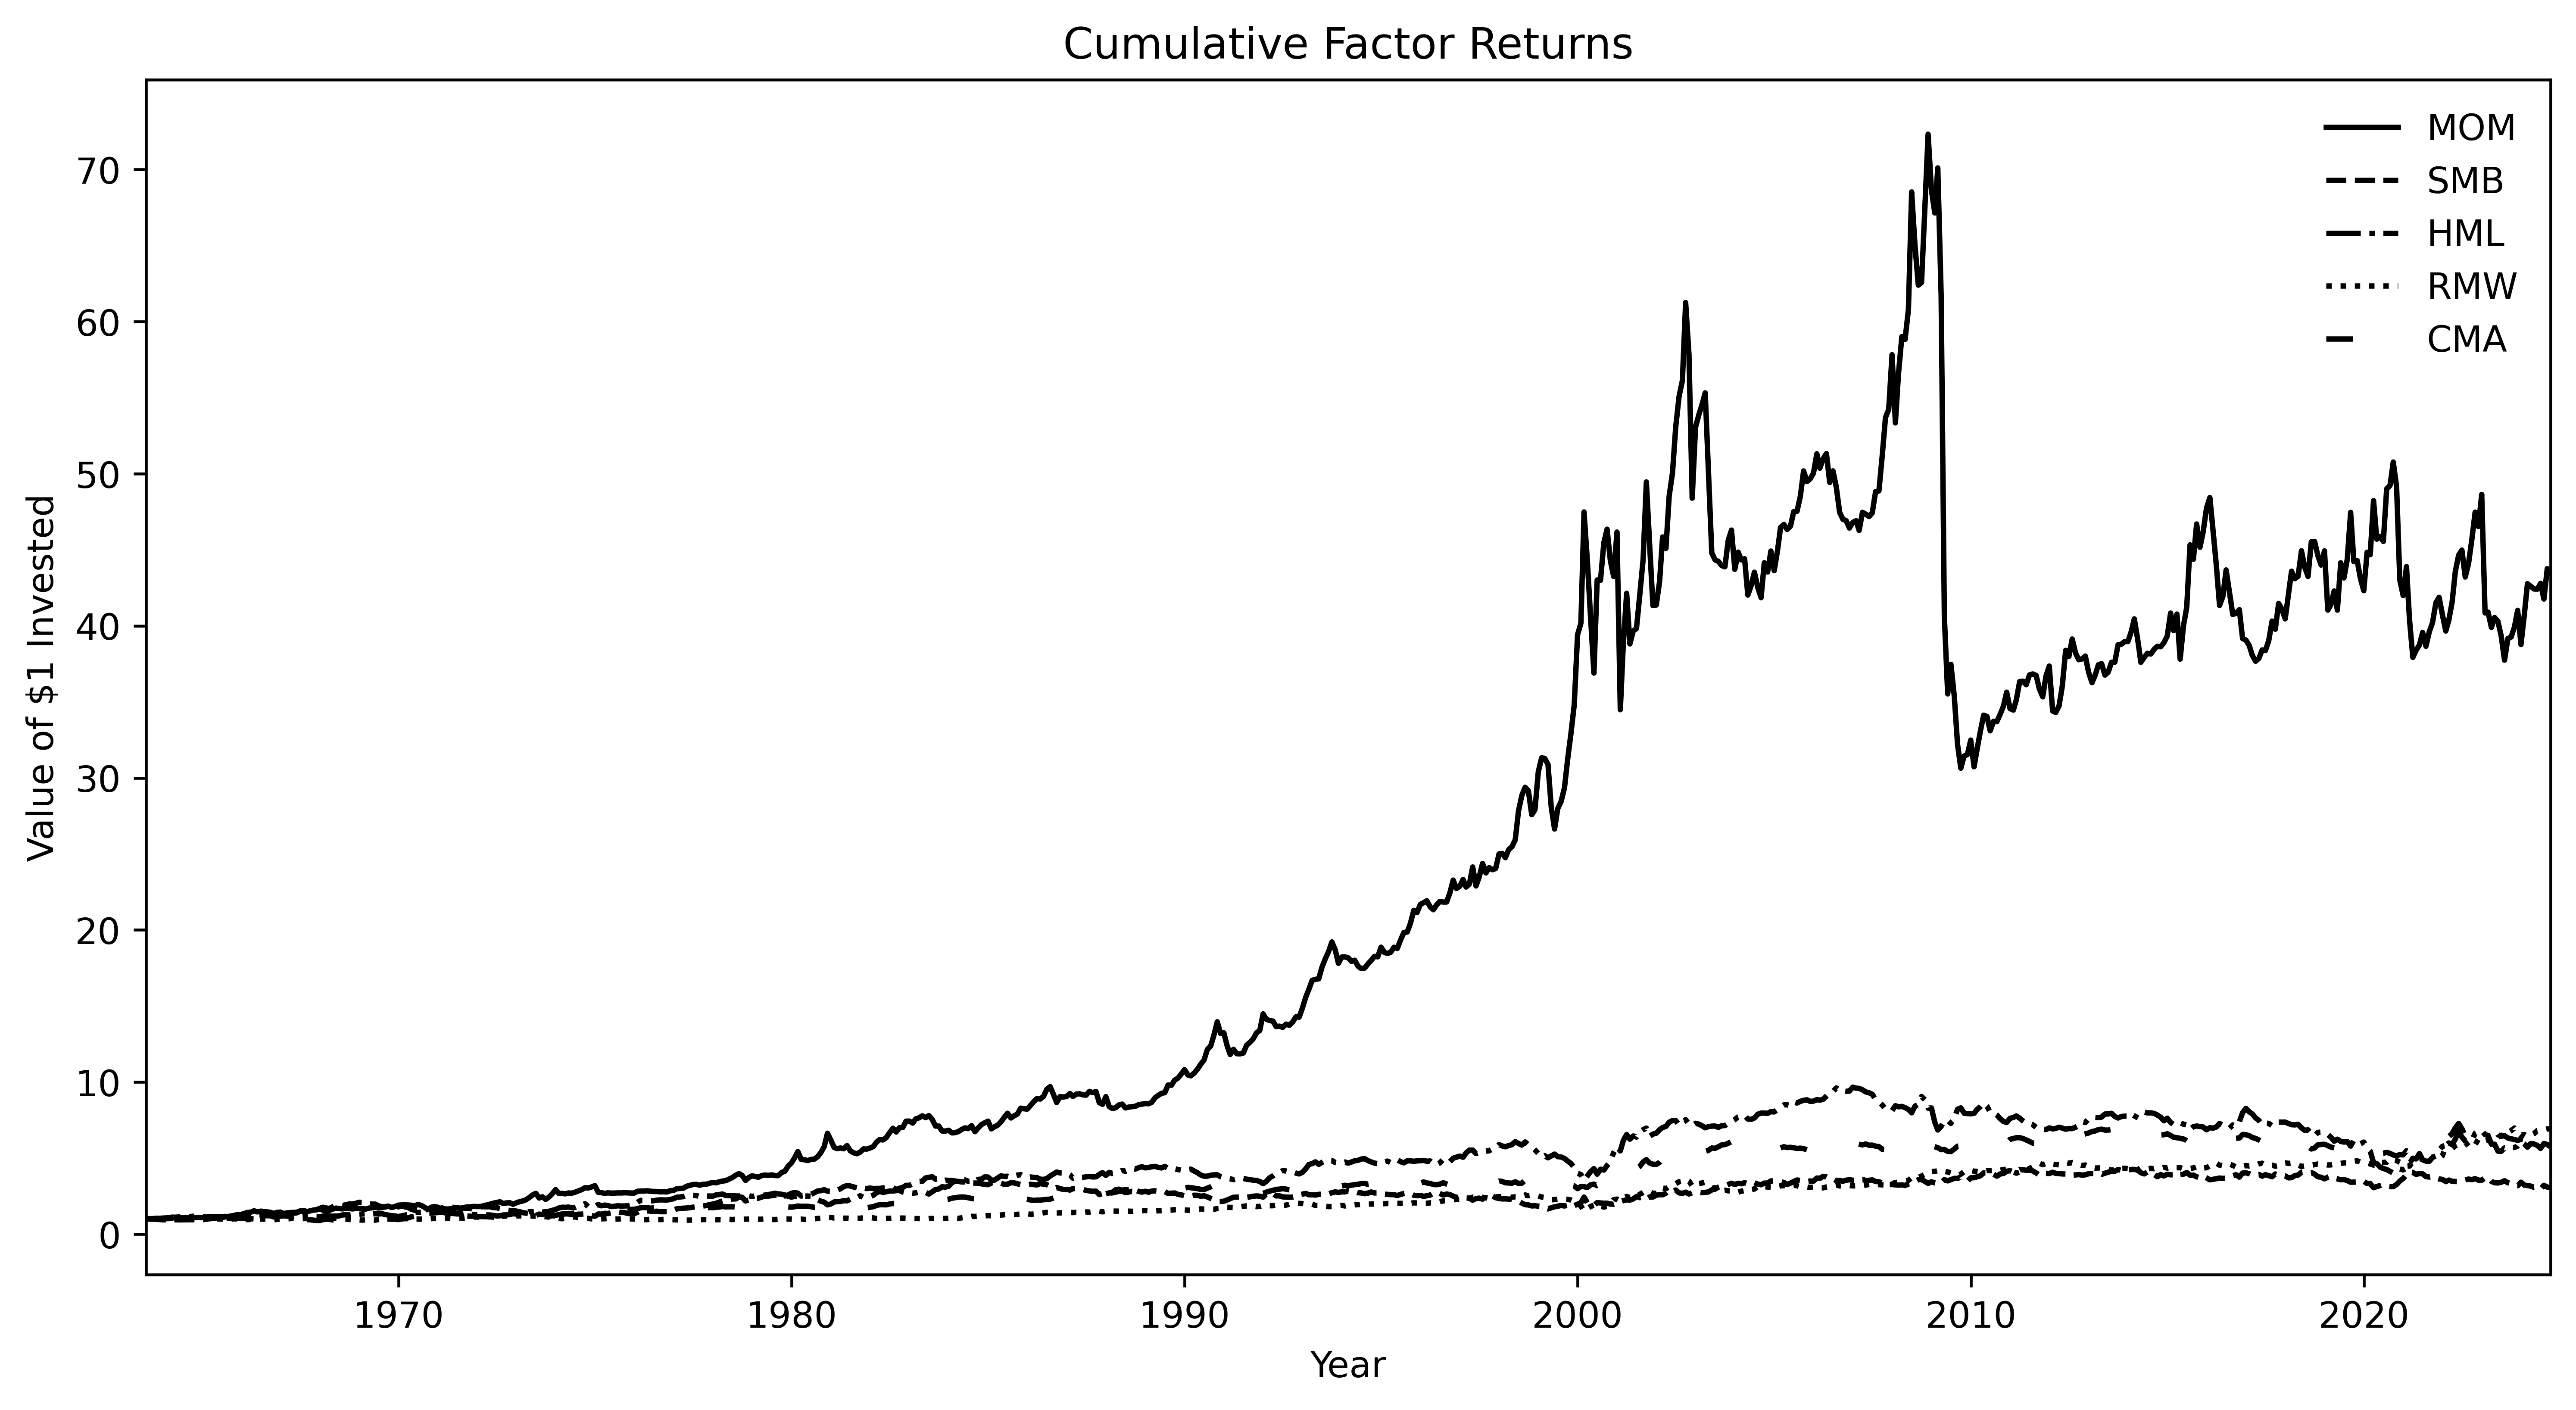

In [38]:
ff_5_mom_factors = ["MOM", "SMB", "HML", "RMW", "CMA"]
ff_5_data = calculateCumulativeReturns(data, ff_5_mom_factors)

plotStrategies(ff_5_data, ff_5_mom_factors, "Cumulative Factor Returns")

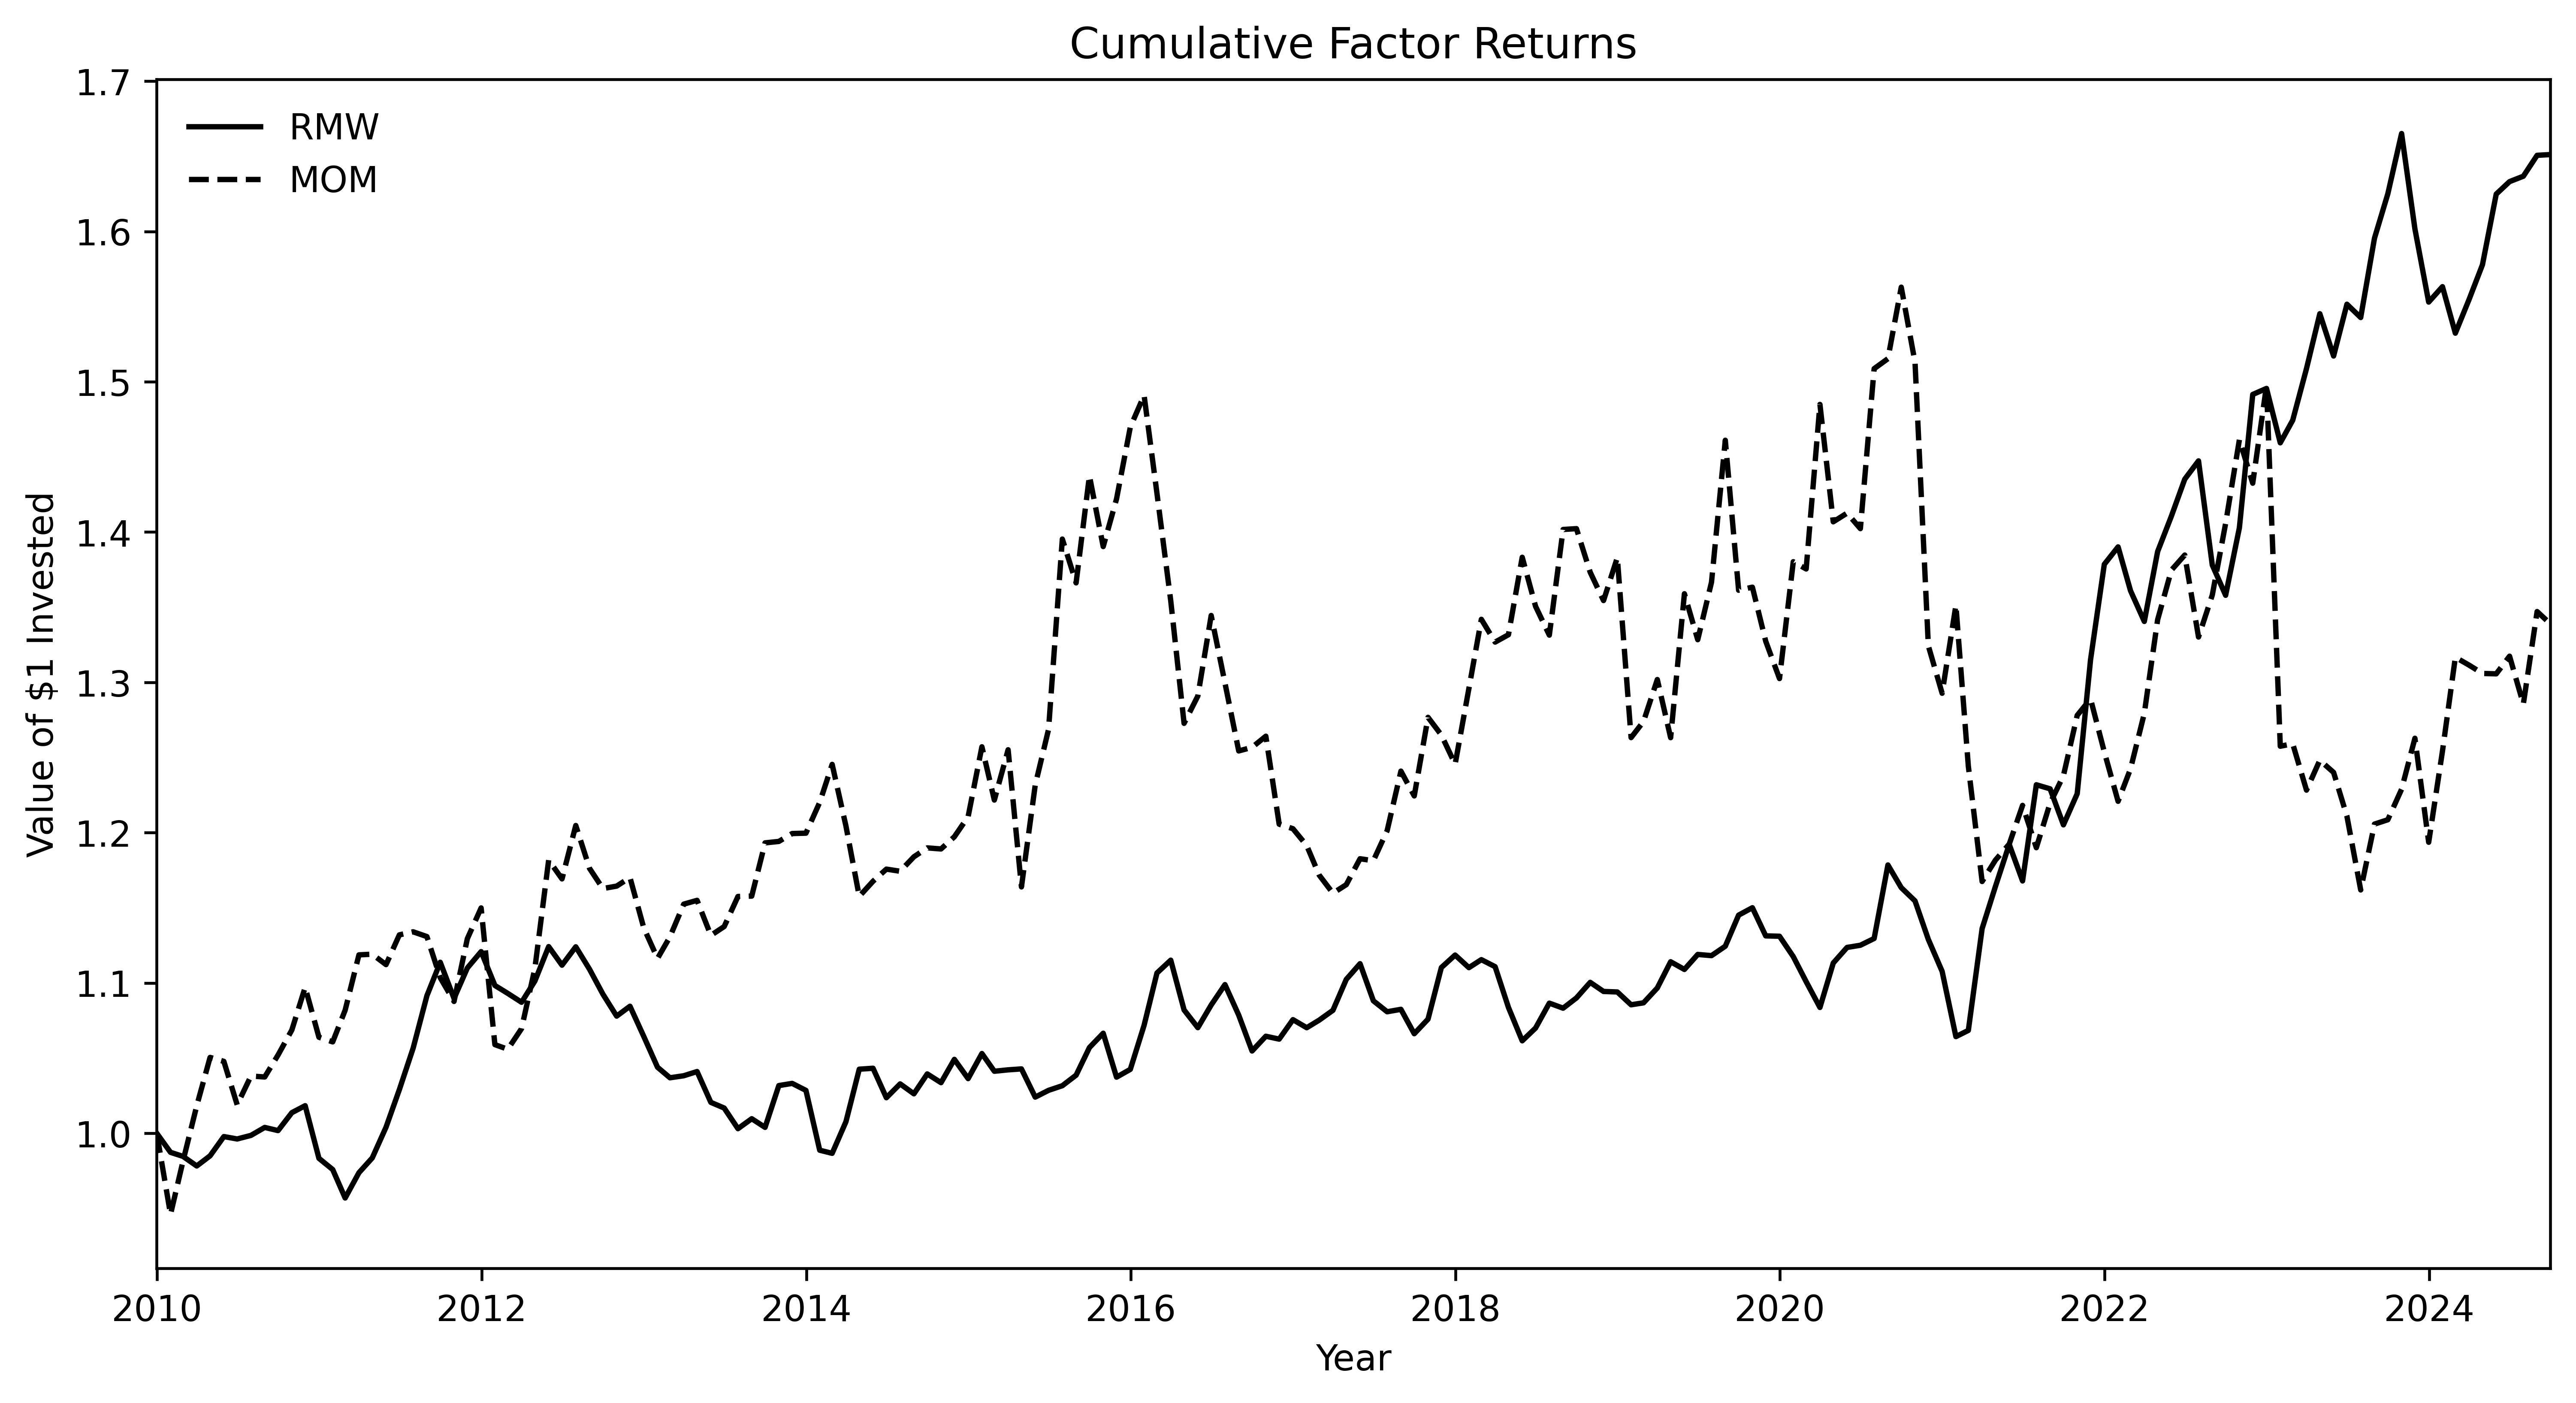

In [39]:
data_subsetted = data[data["Date"] >= "2009-12-31"]

ff_5_mom_factors = ["RMW", "MOM"]
ff_5_data = calculateCumulativeReturns(data_subsetted, ff_5_mom_factors)

plotStrategies(ff_5_data, ff_5_mom_factors, "Cumulative Factor Returns")

### **2.3 ESG & SMB - Cumulative Return**

In [54]:
esg_smb_factors = ["ESG", "ESG_Residual"]
esg_smb_data = calculateCumulativeReturns(data, esg_smb_factors)

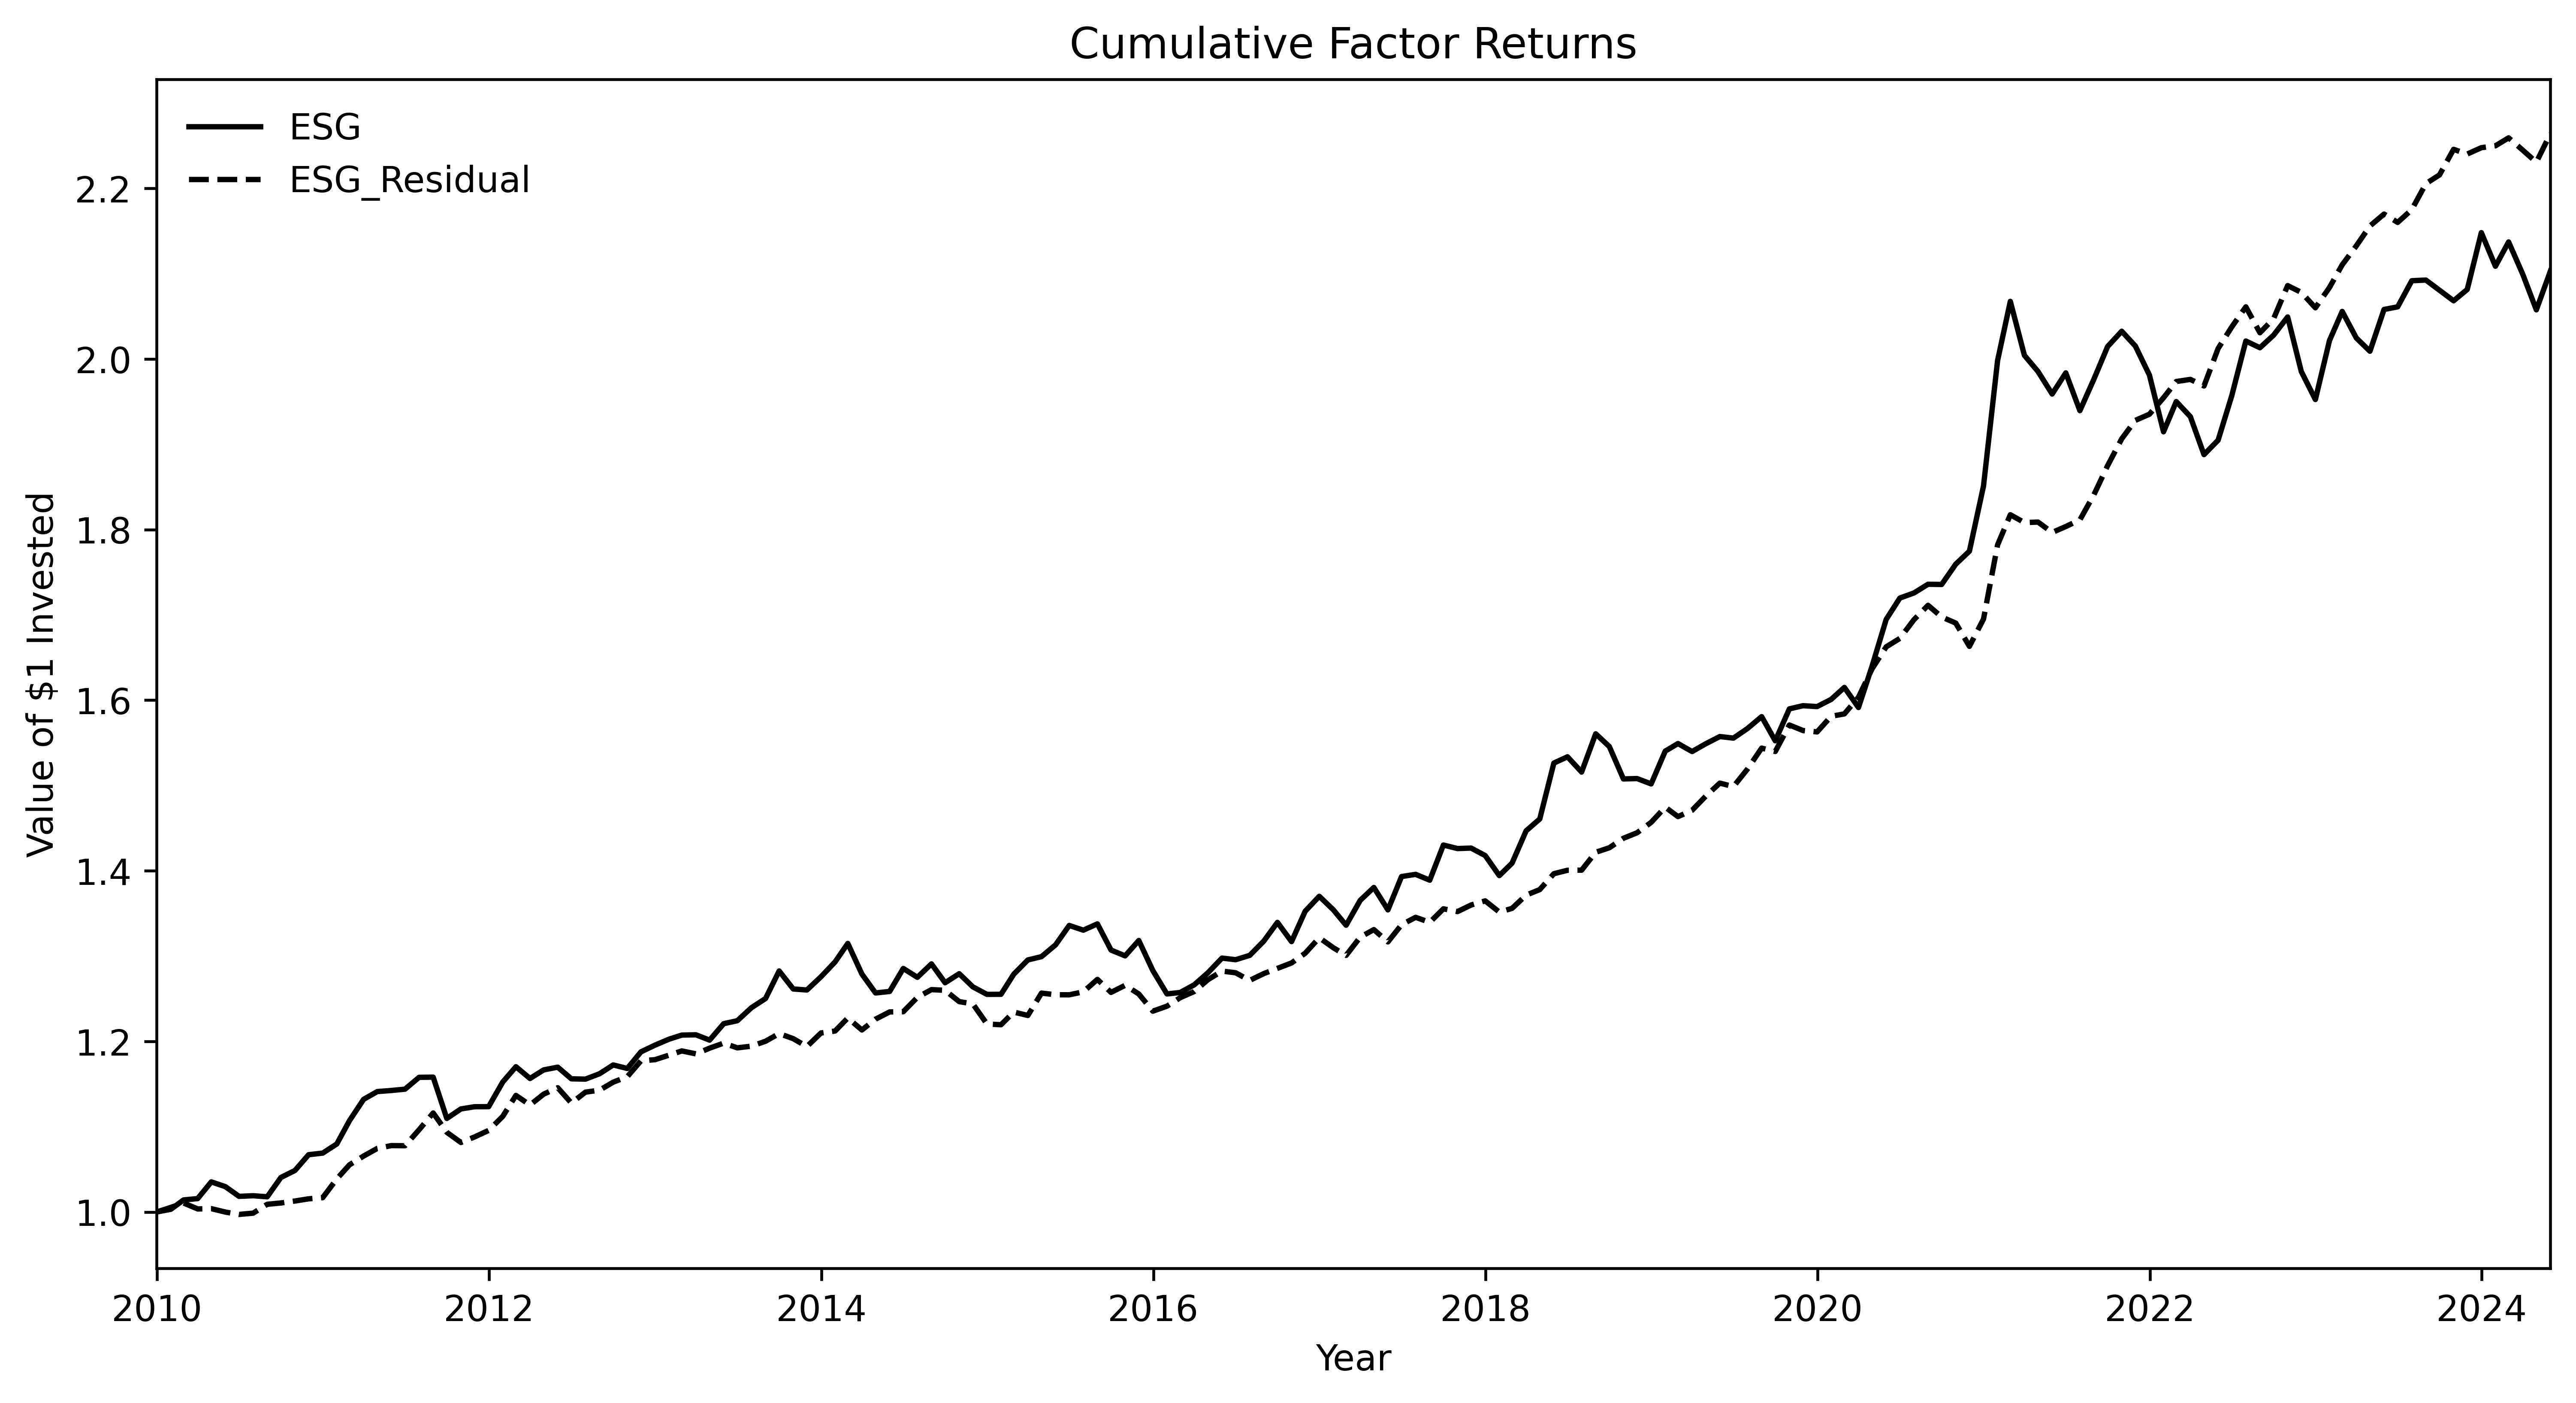

In [55]:
plotStrategies(esg_smb_data, esg_smb_factors, "Cumulative Factor Returns")

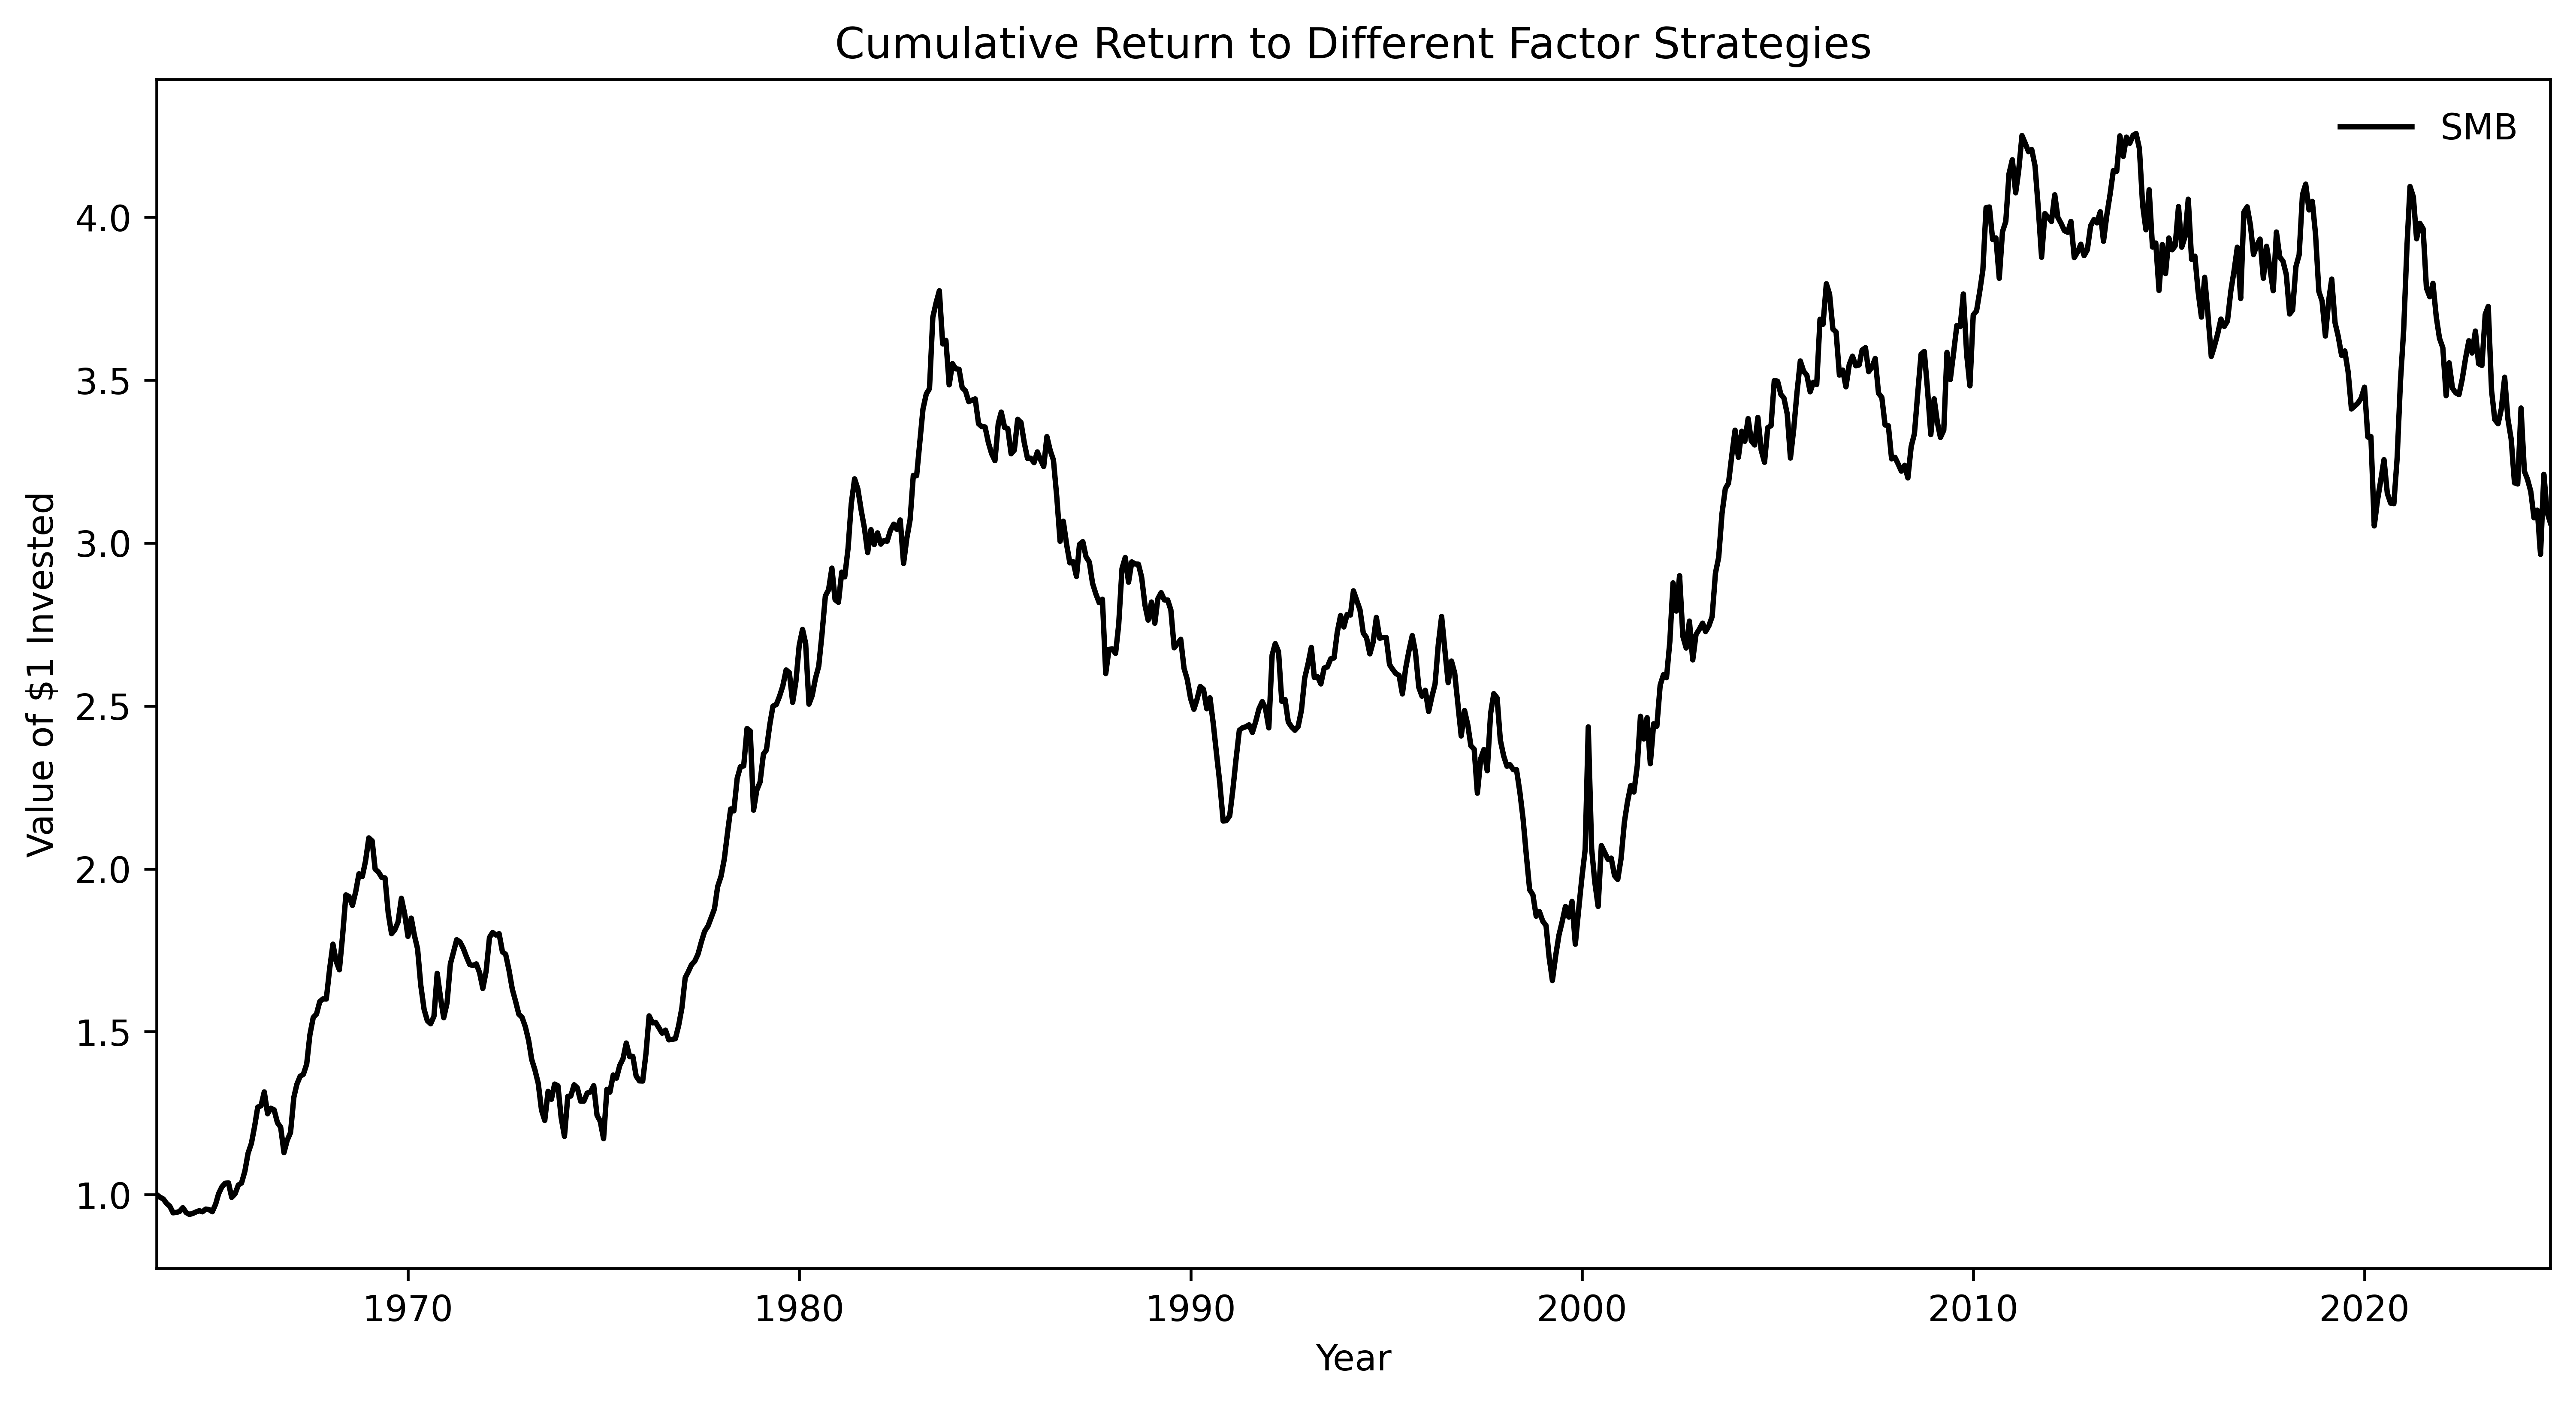

In [56]:
hml_factors = ["SMB"]
hml_data = calculateCumulativeReturns(data, hml_factors)

plotStrategies(hml_data, hml_factors)

### **2.4 ESG & SMB - Heatmap**

In [43]:
factor_columns = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "MOM", "ESG", "ESG_Residual"]

esg_smb_heatmap_data = data[factor_columns].dropna().reset_index(drop = True)

columns = esg_smb_heatmap_data[factor_columns].columns

In [44]:
#Correlation & P-Value Matrices
corr_matrix_pearson = pd.DataFrame(index=columns, columns=columns, dtype=float)
pval_matrix_pearson = pd.DataFrame(index=columns, columns=columns, dtype=float)

for col1 in columns:
    for col2 in columns:

        #Calculates correlation coefficient and p-value
        corr, pval = pearsonr(esg_smb_heatmap_data[col1], esg_smb_heatmap_data[col2])

        #Adds values to dataframes
        corr_matrix_pearson.loc[col1, col2] = corr
        pval_matrix_pearson.loc[col1, col2] = pval

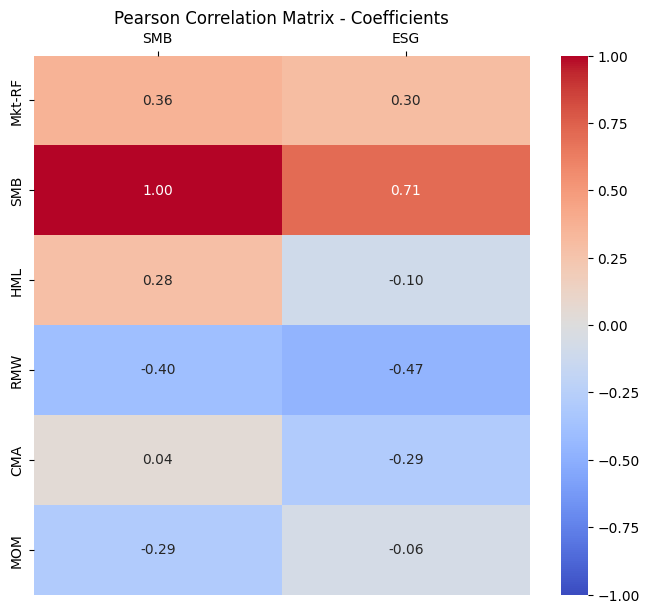

In [45]:
plotHeatmap(corr_matrix_pearson, "Pearson Correlation Matrix - Coefficients", False, ["SMB", "ESG"], ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "MOM"])

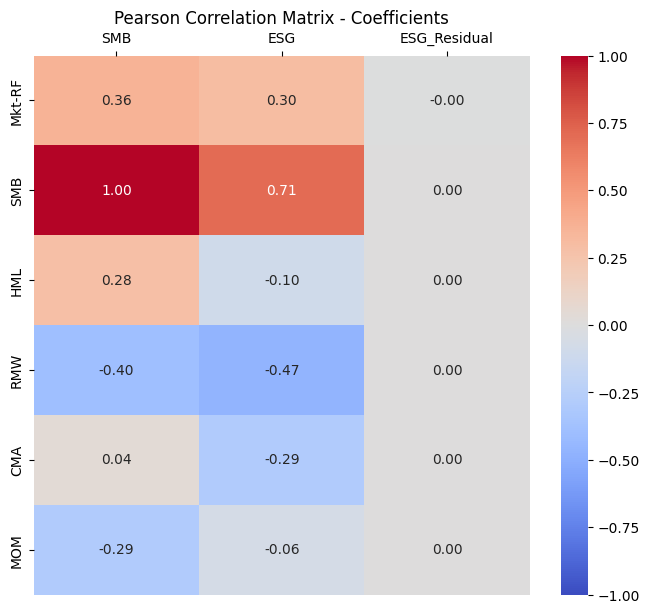

In [46]:
plotHeatmap(corr_matrix_pearson, "Pearson Correlation Matrix - Coefficients", False, ["SMB", "ESG", "ESG_Residual"], ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "MOM"])

### **2.5 ESG Portfolio MCap**

In [47]:
esg_data["Total_MCap_Multiple"] = esg_data["MCap_Total_High"] / esg_data["MCap_Total_Low"]

esg_data[["Date", "Total_MCap_Multiple"]].head()

esg_data["Date"] = pd.to_datetime(esg_data["Date"])

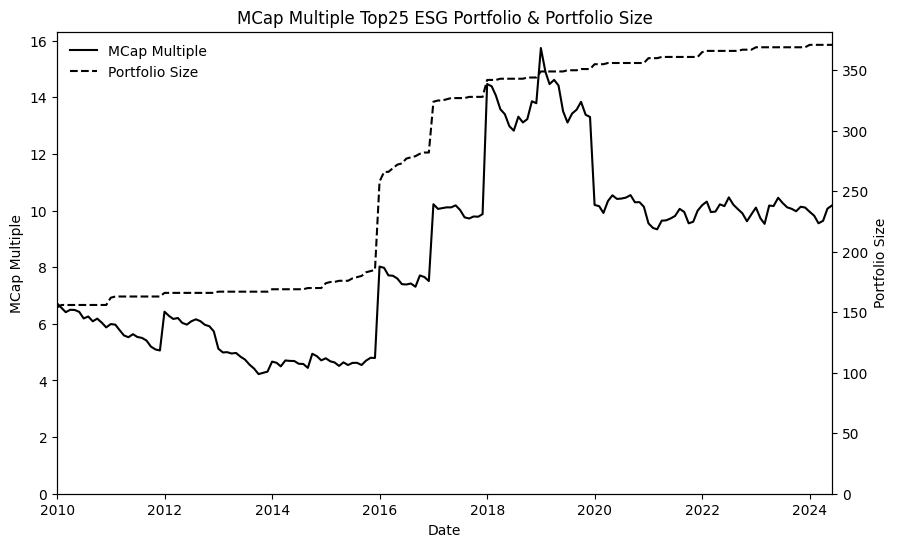

In [48]:
data_list = [esg_data, esg_data]
column_names = ["Total_MCap_Multiple", "Count_High"]
labels = ["MCap Multiple", "Portfolio Size"]

plot2YLinesOverTime(data_list, column_names, labels, "MCap Multiple Top25 ESG Portfolio & Portfolio Size", "Date", "MCap Multiple", "Portfolio Size")

In [49]:
esg_data["Total_MCap_Multiple"].min()

4.224404392678034

In [50]:
esg_data["Total_MCap_Multiple"].max()

15.738789890173036

### **2.6 ESG Portfolio Scores**

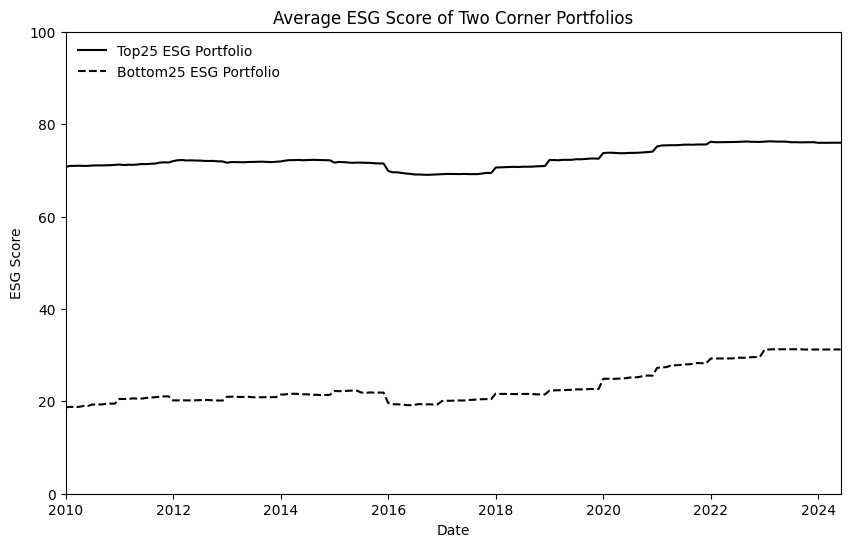

In [51]:
data_list = [esg_data, esg_data]
column_names = ["Avg_ESG_Score_High", "Avg_ESG_Score_Low"]
labels = ["Top25 ESG Portfolio", "Bottom25 ESG Portfolio"]
line_styles = ["-", "--"]

plotLinesOverTime(data_list, column_names, labels, line_styles, "Average ESG Score of Two Corner Portfolios", "Date", "ESG Score", True)

In [52]:
top_avg_esg_score = esg_data["Avg_ESG_Score_High"].mean()
bottom_avg_esg_score = esg_data["Avg_ESG_Score_Low"].mean()

top_bottom_esg_score = esg_data["Avg_ESG_Score_High"].min()
bottom_bottom_esg_score = esg_data["Avg_ESG_Score_Low"].min()

top_top_esg_score = esg_data["Avg_ESG_Score_High"].max()
bottom_top_esg_score = esg_data["Avg_ESG_Score_Low"].max()

print(f"ESG High Portfolio Average ESG Score:{top_avg_esg_score}")
print(f"ESG Low Portfolio Average ESG Score:{bottom_avg_esg_score}")
print(" ")
print(f"ESG High Portfolio Top ESG Score:{top_top_esg_score}")
print(f"ESG Low Portfolio Top ESG Score:{bottom_top_esg_score}")
print(" ")
print(f"ESG High Portfolio Bottom ESG Score:{top_bottom_esg_score}")
print(f"ESG Low Portfolio Bottom ESG Score:{bottom_bottom_esg_score}")

ESG High Portfolio Average ESG Score:72.5039940720772
ESG Low Portfolio Average ESG Score:23.277197658513007
 
ESG High Portfolio Top ESG Score:76.27085718565142
ESG Low Portfolio Top ESG Score:31.276513933650225
 
ESG High Portfolio Bottom ESG Score:69.0247465873083
ESG Low Portfolio Bottom ESG Score:18.73365781287322


### **2.5 Heatmap (All Factors)**

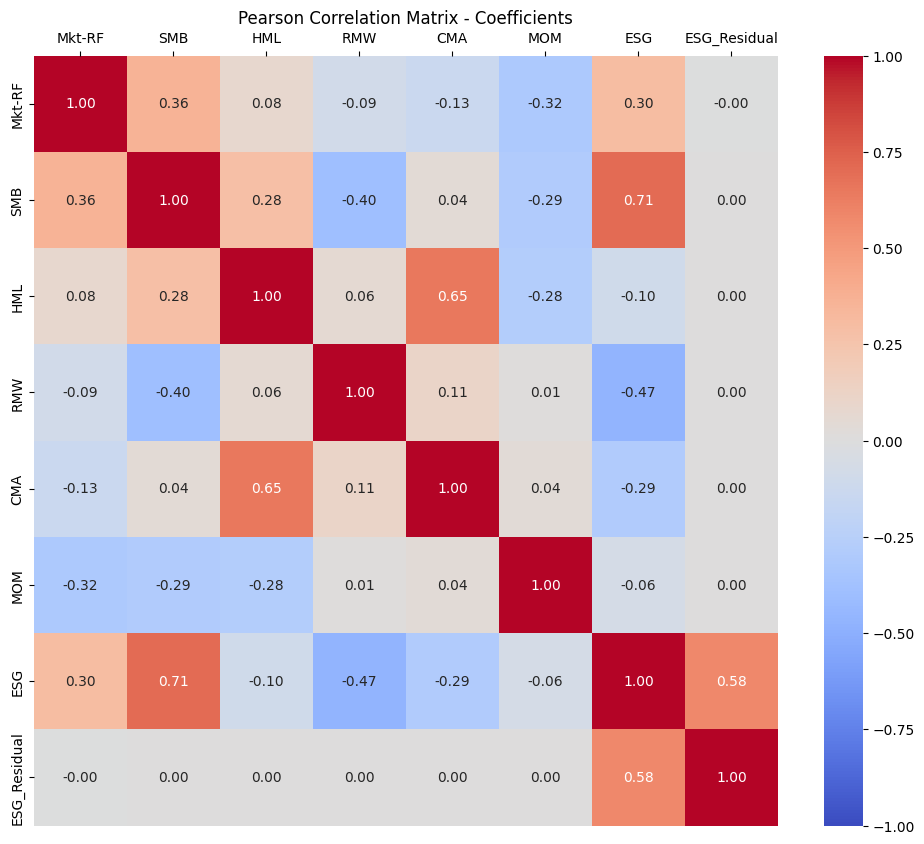

In [53]:
plotHeatmap(corr_matrix_pearson, "Pearson Correlation Matrix - Coefficients", False)